# Evaluate JSON Generation Ability

Use a HuggingFace dataset of BBC News articles to determine the ability of various OpenAI models to generate correct JSON.

In [15]:
from collections import defaultdict
import asyncio
from enum import StrEnum
import json
import math
import re

from datasets import load_dataset
from openai import AsyncOpenAI, OpenAI
from pydantic import BaseModel, Field, ValidationError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd


In [2]:
nest_asyncio.apply()

## Load Dataset

Load the dataset of BBC News articles. Combine the test and train datasets since we won't be training a model.

In [3]:

dataset = load_dataset("SetFit/bbc-news")

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
combined_df = pd.concat([train_df, test_df])

print("Dataset Overview:")
print(f"Dataset size: {len(combined_df)}")
print("\nLabel distribution in training set:")
print(combined_df['label_text'].value_counts())
print("\nSample text from training set:")
print(combined_df['text'].iloc[0][:200])

train_df['text_length'] = train_df['text'].str.len()
print(f"\nText length mean: {train_df['text_length'].mean():.2f}")

Dataset Overview:
Dataset size: 2225

Label distribution in training set:
label_text
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Sample text from training set:
wales want rugby league training wales could follow england s lead by training with a rugby league club.  england have already had a three-day session with leeds rhinos  and wales are thought to be in

Text length mean: 2288.95


## Declare Output Schema

Declare the output schema that we want the LLM to generate

In [4]:
class ArticleCategory(StrEnum):
    BUSINESS = "business"
    ENTERTAINMENT = "entertainment"
    POLITICS = "politics"
    SPORT = "sport"
    TECH = "tech"

class NamedEntityType(StrEnum):
    COMPANY = "company"
    COUNTRY = "country"
    LOCATION = "location"
    PERSON = "person"
    TEAM = "team"

class NamedEntity(BaseModel):
    name: str = Field(description="Name of the person, company, etc.")
    type: NamedEntityType = Field(description="Type of named entity")

class NewsArticle(BaseModel):
    title: str = Field(description="Appropriate headline for the news article")
    category: ArticleCategory = Field(description="Category of news that the article belongs to")
    mentioned_entities: list[NamedEntity] = Field(description="List of all named entities in the article", default_factory=list)
    summary: str = Field(description="Brief summary of the article content.")
    length: int = Field(description="Length of the article in words.")



In [10]:
news_article_schema = NewsArticle.model_json_schema()
print(json.dumps(news_article_schema, indent=2))

{
  "$defs": {
    "ArticleCategory": {
      "enum": [
        "business",
        "entertainment",
        "politics",
        "sport",
        "tech"
      ],
      "title": "ArticleCategory",
      "type": "string"
    },
    "NamedEntity": {
      "properties": {
        "name": {
          "description": "Name of the person, company, etc.",
          "title": "Name",
          "type": "string"
        },
        "type": {
          "$ref": "#/$defs/NamedEntityType",
          "description": "Type of named entity"
        }
      },
      "required": [
        "name",
        "type"
      ],
      "title": "NamedEntity",
      "type": "object"
    },
    "NamedEntityType": {
      "enum": [
        "company",
        "country",
        "location",
        "person",
        "team"
      ],
      "title": "NamedEntityType",
      "type": "string"
    }
  },
  "properties": {
    "title": {
      "description": "Appropriate headline for the news article",
      "title": "Title",
    

## Create LLM Prompt

This prompt injects the JSON schema that was generated as well as a news article to analyze.

In [7]:
EXTRACTION_PROMPT = """
Read the news article below and extract the information into a
JSON object. This is the schema you should use to extract the
data. It's provided in standard JSON Schema format.

```json
{news_article_schema}
```

Here is the news article to generate the JSON data for. The article
is surrounded by triple backticks.

```
{news_article}
```

Format your response as a JSON object surrounded by triple backticks
with the 'json' identifier like this:
```json
your JSON object here
```

Be sure to follow the provided schema exactly.
"""

## Run Evaluation

Run an evaluation for all models in `model_names`. The criteria for passing is if the output text can be parsed into a `NewsArticle` object. If the validation fails for any reason then the test fails. The contents of the `NewsArticle` object aren't evaluated.

If this notebook is being run in Github Codespaces, you'll need to set `OPENAI_API_KEY` as a codespace secret in user settings. If it's being run locally then you'll need to set the environment variable `OPENAI_API_KEY`.

In [7]:
async def extract_article_data(article: str, model_name: str, client: AsyncOpenAI, semaphore: asyncio.Semaphore) -> bool:
    """Returns true if JSON is appropriately formatted"""

    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article
    )

    async with semaphore:
        response = await client.responses.create(
            model=model_name,
            input=formatted_prompt,
            temperature=0.0,
        )
    extracted_json = response.output_text
    json_match = re.search(r'```json\s*(.*?)\s*```', extracted_json, re.DOTALL)

    if json_match:
        json_content = json_match.group(1).strip()

        try:
            parsed_json = json.loads(json_content)
            _ = NewsArticle.model_validate(parsed_json)
            return True
        except (json.JSONDecodeError, ValidationError) as e:
            return False
    else:
        return False

In [9]:
openai_client = AsyncOpenAI()

ARTICLE_COUNT = 100
MAX_CONCURRENT_TASKS = 3
loop_semaphore = asyncio.Semaphore(MAX_CONCURRENT_TASKS)

success_count = 0
model_names=["gpt-3.5-turbo", "gpt-4-turbo", "gpt-4o-mini"]

results = defaultdict(list)
for model_name in model_names:
    tasks = [extract_article_data(article, model_name, openai_client, loop_semaphore) for article in combined_df['text'][:ARTICLE_COUNT]]

    for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        results[model_name].append(await f)
        
    success_count = sum(1 for result in results[model_name] if result)
    print(f"For {model_name} successfully validated {success_count} of {ARTICLE_COUNT} records")

  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-3.5-turbo successfully validated 84 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4-turbo successfully validated 90 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4o-mini successfully validated 69 of 100 records


# Display Results

In [10]:
model_success_rates = {}
for model_name, results_list in results.items():
    success_count = sum(1 for result in results_list if result)
    success_rate = (success_count / len(results_list)) * 100
    model_success_rates[model_name] = success_rate


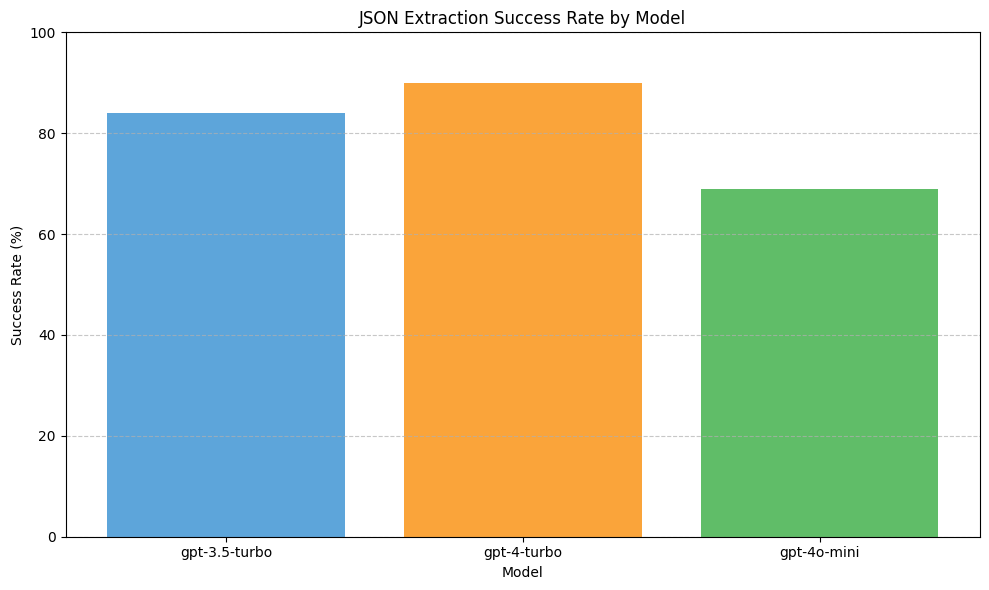

In [11]:

models = list(results.keys())
success_rates = [model_success_rates[model] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, success_rates, color=['#5DA5DA', '#FAA43A', '#60BD68'])

plt.xlabel('Model')
plt.ylabel('Success Rate (%)')
plt.title('JSON Extraction Success Rate by Model')
plt.ylim(0, 100)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyze Logprobs


In [19]:
def plot_token_probabilities(response, tokens_to_show=10, top_n=5):
    """Create horizontal bar charts for token probabilities"""
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import numpy as np
    
    # Set up the figure with a grid layout
    fig = plt.figure(figsize=(15, tokens_to_show * 2))
    gs = GridSpec(tokens_to_show, 1, figure=fig)
    
    # Process each token
    for i in range(min(tokens_to_show, len(response.choices[0].logprobs.content))):
        token_info = response.choices[0].logprobs.content[i]
        token_text = token_info.token
        
        # Get top_n alternatives and their probabilities
        labels = []
        probs = []
        
        for logprob_item in token_info.top_logprobs[:top_n]:
            labels.append(logprob_item.token.replace('\n', '\\n'))
            probs.append(np.exp(logprob_item.logprob))
        
        # Create subplot for this token
        ax = fig.add_subplot(gs[i])
        
        # Plot horizontal bars
        y_pos = np.arange(len(labels))
        bars = ax.barh(y_pos, probs, align='center', alpha=0.8, 
                color=['#1f77b4' if label == token_text else '#7f7f7f' for label in labels])
        
        # Add labels and values
        for bar, prob in zip(bars, probs):
            width = bar.get_width()
            ax.text(max(0.01, width - 0.15), bar.get_y() + bar.get_height()/2, 
                   f'{prob:.3f}', va='center', color='white', fontweight='bold')
        
        # Customize the plot
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"'{l}'" for l in labels])
        ax.set_title(f"Token {i}: '{token_text}'")
        ax.set_xlim(0, 1.05)
        ax.set_xlabel('Probability')
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    return fig


) missing from current font.41.py:46: UserWarning: Glyph 13 (
  plt.tight_layout()
/tmp/ipykernel_1906/3307603841.py:46: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
) missing from current font.ython3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


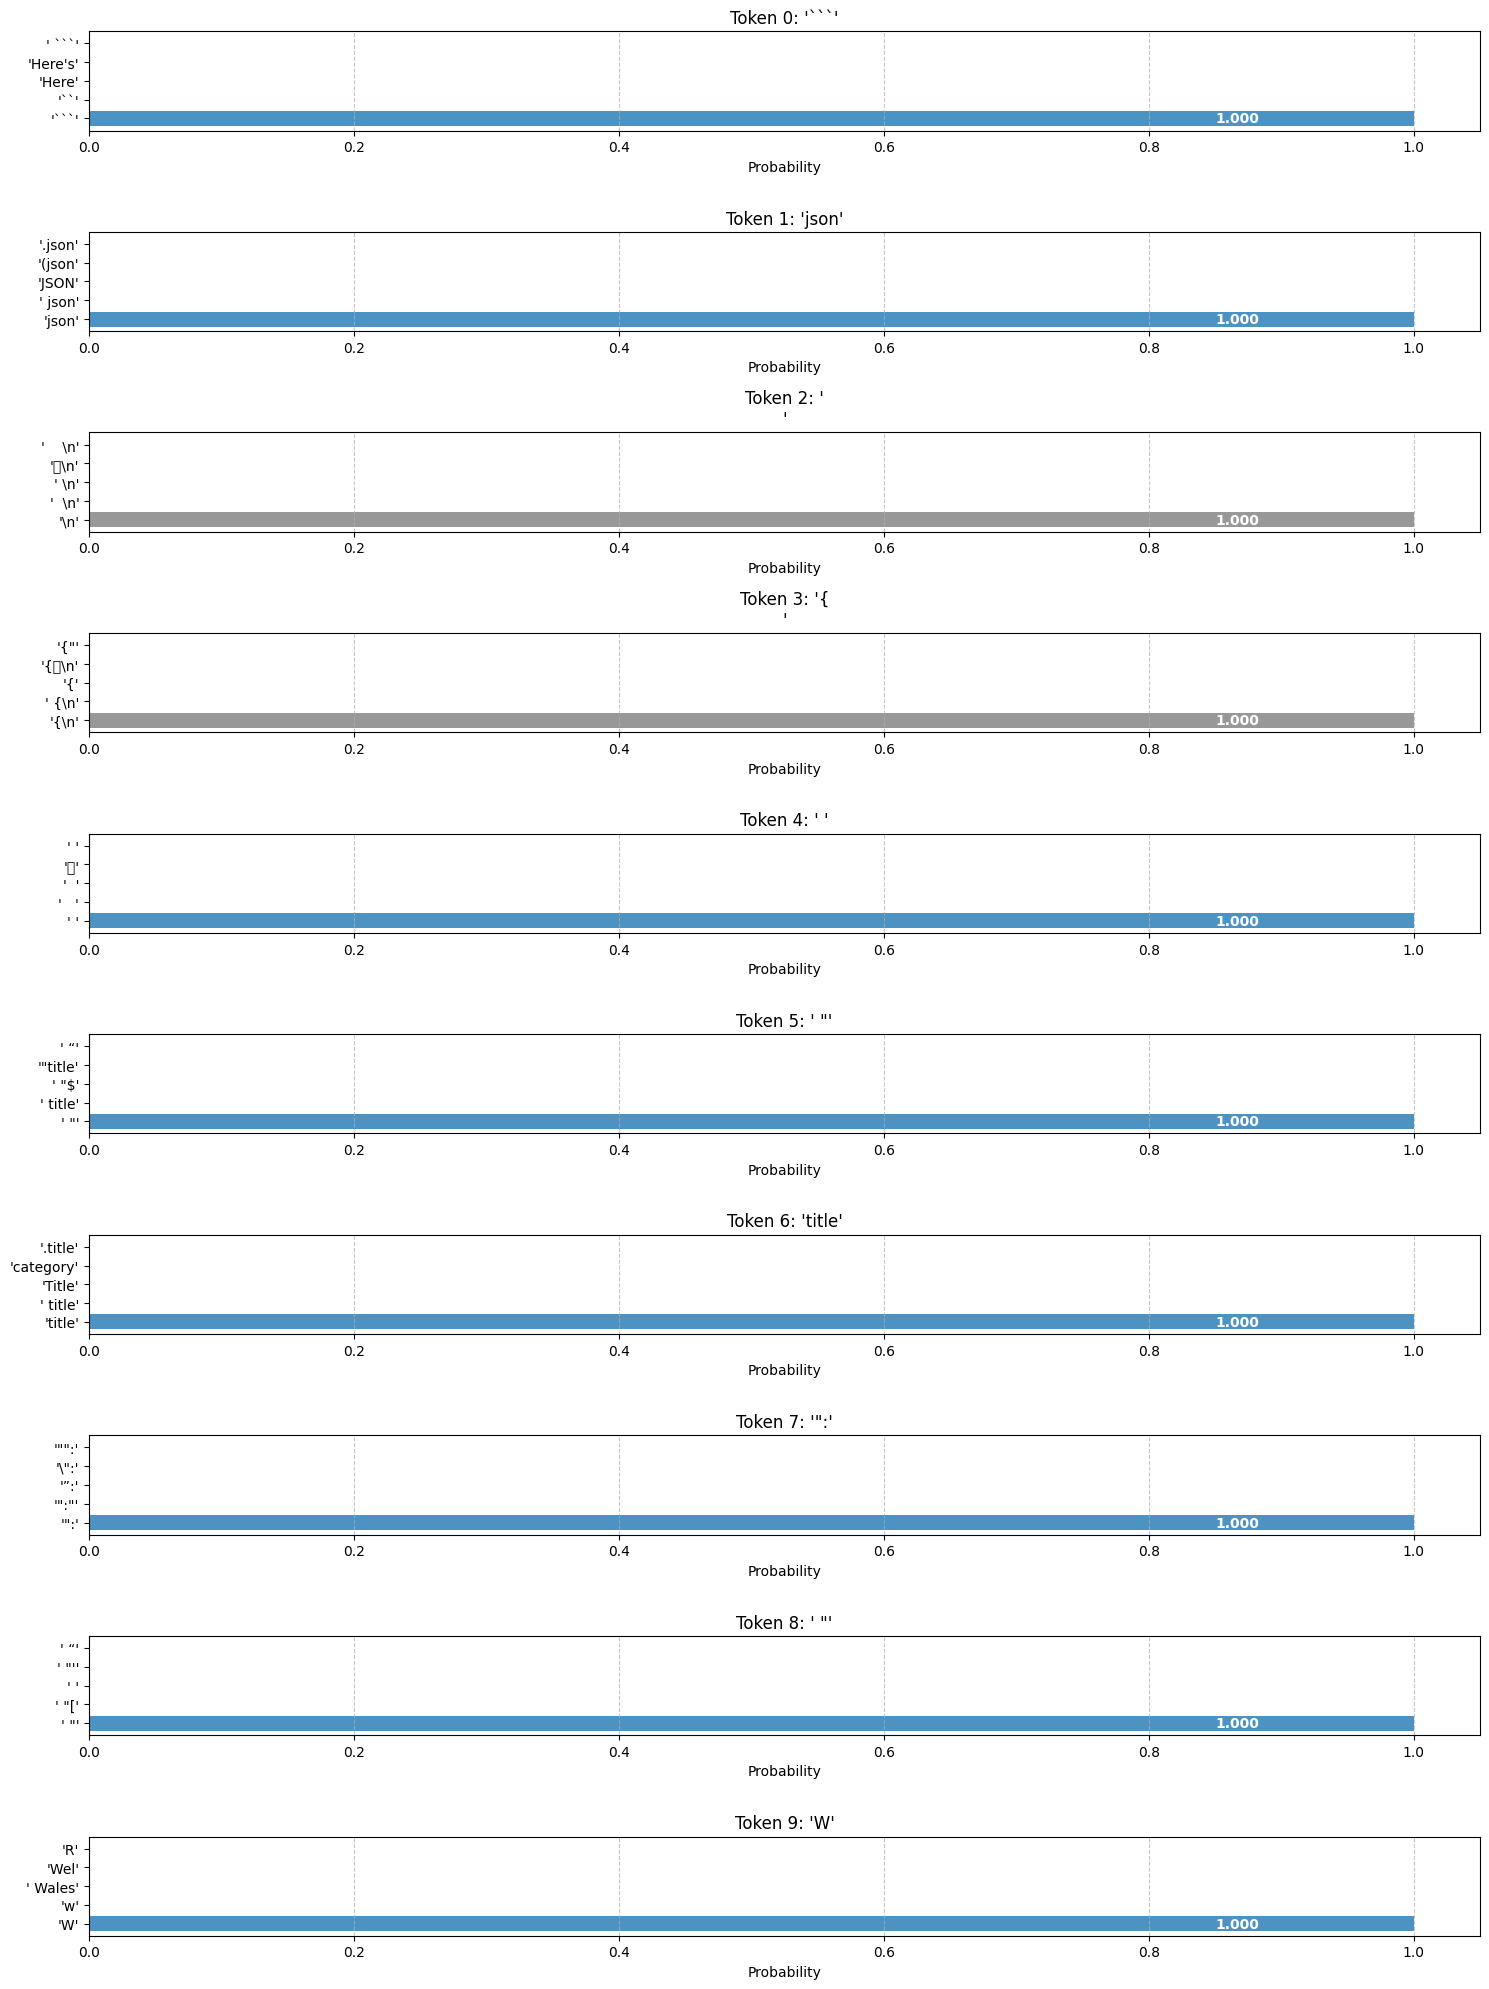

In [20]:
sync_client = OpenAI()
article = combined_df['text'].iloc[0]

formatted_prompt = EXTRACTION_PROMPT.format(
    news_article_schema=json.dumps(news_article_schema, indent=2),
    news_article=article
)

response = sync_client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": formatted_prompt}],
            temperature=0.0,
            logprobs=True,
            top_logprobs=5
        )

# for i in range(10):
#     top_n = response.choices[0].logprobs.content[i].top_logprobs 
#     probability = [(top_log_prob.token, round(math.exp(top_log_prob.logprob), 6)) for top_log_prob in top_n]
#     print(probability)


# Usage
fig = plot_token_probabilities(response, tokens_to_show=10)
plt.show()